In [32]:
%pylab inline
# next 2 lines allow to automatically reload modules that have been changed externally
%reload_ext autoreload
%autoreload 2
import os, sys
sys.path.insert(0, '/home/did/RTC/SMART-G/')
from luts.luts import LUT, MLUT, Idx, merge, read_mlut

from smartg.albedo import Albedo_spectrum, Albedo_speclib, Albedo_cst
from smartg.bandset import BandSet
from smartg.smartg import Smartg, Sensor, multi_profiles, reduce_diff
from smartg.smartg import RoughSurface, LambSurface, FlatSurface, Environment, multi_profiles
from smartg.atmosphere import AtmAFGL, AeroOPAC, CompOPAC, CloudOPAC, diff1, read_phase, Species, trapzinterp
from smartg.water import IOP_1, IOP, IOP_profile, IOP_Rw, IOP_base
from smartg.reptran import REPTRAN, reduce_reptran
#from smartg.kdis import KDIS, reduce_kdis
from smartg.tools.tools import SpherIrr, Irr, reduce_Irr
from smartg.tools.cdf import ICDF
from smartg.tools.phase import integ_phase, calc_iphase

from smartg.tools.smartg_view import compare, plot_polar, spectrum , mdesc 
from smartg.tools.smartg_view import spectrum_view,transect_view,profile_view,phase_view,smartg_view,input_view
import warnings

from scipy.interpolate import interp1d
warnings.filterwarnings("ignore")

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [158]:
import pickle
import pandas as pd
INFO = False

model_dir = '/home/did/RTC/SMART-G/smartg/bio_optical_model/'

## combine all dino species into one dataframe
with open(model_dir + 'classes_subset_v1.p', 'rb') as fp:
    classes = pickle.load(fp)
    
## Open the pickle file and inspect the list of run names
with open(model_dir + 'case1_runlist.p', 'rb') as fp:
    case1 = pickle.load(fp)
runlist = list(case1.keys())
print (*runlist, sep='\n')

## Choose random runs to work with and inspect
runID1 = np.random.choice(runlist)
runID2 = np.random.choice(runlist)
runData1 = case1[runID1]
runData2 = case1[runID2]

if INFO:
    print ('\nChosen run ID 1: {}'.format(runID1))
    print ('4 Main aquatic components: {}'.format(list(case1[runID1].keys())))
    phyto1 = runData1['Phyto']
    print ('PHYTOPLANKTON COMPONENT VARIABLES:\n')
    print ('\n'.join(list(phyto1.keys())))
    print ('########################################')
    print ('\nChosen run ID 2: {}'.format(runID2))
    print ('4 Main aquatic components: {}'.format(list(case1[runID2].keys())))
    det2 = runData2['Det']
    min2 = runData2['Min']
    cdom2= runData2['CDOM']
    print ('DETRITUS COMPONENT VARIABLES:\n')
    print ('\n'.join(list(det2.keys())))
    print ('MINERAL COMPONENT VARIABLES:\n')
    print ('\n'.join(list(min2.keys())))
    print ('CDOM COMPONENT VARIABLES:\n')
    print ('\n'.join(list(cdom2.keys())))

0.565_0.007_0.009_0.008_EnHE9AxSDs
0.224_0.008_0.009_0.004_EdfgnmNsMZ
0.757_0.006_0.029_0.057_PGFgWTdMFZ
0.563_0.015_0.033_0.032_FShk4FqxnG
0.319_0.015_0.004_0.010_8Q8RyNenqY
1.924_0.042_0.072_0.189_9pJcQSfggi
1.648_0.035_0.028_0.181_5R3aNErbM3
0.313_0.004_0.004_0.012_HNsipBY6Q6
0.147_0.002_0.006_0.002_5pN8wfkXta
0.287_0.007_0.014_0.008_E4HuiaAT5H


In [148]:
# Static data : IOPs wavelength grids
WAV = np.linspace(400, 900., num=201, dtype=np.float32)
WAV_CDOM = np.arange(240., 900., 2.5, dtype=np.float32)

def norm_vsf(vsf, angles):
    '''
    return the normalized VSF in the sense of SMART-G
    i.e. Sum(-1,1) P(mu) dmu = 2.
    output VSF has the same shape as the input VSF
    '''
    theta = np.deg2rad(angles)
    d1    = np.diff(theta)
    dtheta = np.append(d1,d1[0])
    norm   = np.sum(vsf * np.sin(theta) * dtheta, axis=2)
    
    return 2*vsf/norm[:,:,None]


def import_vsf(vsf_list, wav, Z, angles):
    '''
    format the list of input VSF's to SMART-G
    each VSF should have the shape (1, wav.size, angles.size)
    the different VSFs in the list correspond to the vertical starting 
    from the surface
    the max number of VSF's is Z.size, if it is lower, last VSF in the list is applied
    until the sea bottom
    
    Output:
        LUT object adapted to SMART-G, with 4 dimensions (WAV, Z, Stokes parameter (4), angles)
    '''
    Nlevel = len(vsf_list)
    Nwav   = vsf_list[0].shape[1]
    Nangle = vsf_list[0].shape[2]
    Nstk   = 4
    assert wav.shape[0]==Nwav
    assert angles.shape[0]==Nangle
    dat    = np.zeros((Nwav, Nlevel, Nstk, Nangle), dtype=np.float32)
    test   = np.concatenate([norm_vsf(vsf, angles) for vsf in vsf_list]).swapaxes(0,1)[:,:,:]
    dat[:,:,0,:] = test
    dat[:,:,1,:] = test
    
    return LUT(dat, names = ['wav_phase_oc', 'z_phase_oc', 'stk', 'theta_oc'],
                        axes = [wav, Z[:Nlevel], None, angles])


def truncate(pha, ang_trunc=10.):
    '''
    Phase matrix truncation
    
    Inputs:
        Phase Matix LUT and truncation angle
    Outputs:
        Truncated Phase Matrix LUT and truncation coefficient
    '''
    norm=integ_phase(np.radians(pha.axis('theta_oc')), (pha.data[:,:,0,:] + pha.data[:,:,1,:])/2.)
    NANG=pha.axis('theta_oc').size
    ang = np.linspace(0, np.pi, NANG, dtype='float64')
    itronc = int(NANG * ang_trunc/180.)
    #
    pha.data[:,:,0,:itronc] = pha.data[:,:,0,itronc][:,:,None]
    pha.data[:,:,1,:itronc] = pha.data[:,:,1,itronc][:,:,None]
    pha.data[:,:,2,:] = 0.
    pha.data[:,:,3,:] = 0.
    trunc = norm/integ_phase(np.radians(pha.axis('theta_oc')),
                             (pha.data[:,:,0,:] + pha.data[:,:,1,:])/2.) 
    
    return pha * trunc[:,:,None,None], trunc.flatten()


def import_iop(ap_list, bp_list, ac_list, vsf_list, wav, wav_vsf, Z, angles, 
               aw_list=None, bw_list=None, ang_trunc=None, ALB=Albedo_cst(0.)):
    '''
    format all IOP's to SMART-G inputs
    
    Inputs:
        ap_list : list of ap (particulate absorption in m-1) arrays of size wav.size, 
            the list should have Z.size elements ans represents the vertical distribution from surface to bottom. 
            the first ap arrays is ignored in the computation.
        bp_list : same for particulate scattering
        ac_list : same for CDOM absorption
        vsf_list: each VSF should have the shape (1, wav.size, angles.size)the different VSFs 
            in the list correspond to the vertical starting from the surface. The max number of VSF's is Z.size,
            if it is lower, last VSF in the list is applied until the sea bottom
        wav : wavelengths of absorption and scattering coefficients
        wav_vsf : wavlengths os VSF's
        Z   : depth grid in m (negative convention)
        angles : scateering angles in degree
    
    Keywords:
        aw_list: same as ap_list but for pure water (default: None, computed from SMART-G itself)
        bw_list: same as bp_list but for pure water (default: None, computed from SMART-G itself)
        ang_trunc: truncation angle in degree (default: None, no truncation)
        ALB : Albedo object from SMART-G (Albedo_spectrum, Albedo_speclib, Albedo_cst) 
            for seafloor albedo (default: black albedo, Albedo_cst(0.))
            
    Output : MLUT water optical properties computed for the grid (wav, Z), for input in the Smartg run() method,
             water keyword
        
    '''
    pha = import_vsf(vsf_list, wav_vsf, Z, angles)
    ap  = np.stack(ap_list, axis=1)
    ac  = np.stack(ac_list, axis=1)
    bp  = np.stack(bp_list, axis=1)
    aw  = np.stack(aw_list, axis=1) if aw_list is not None else None
    bw  = np.stack(bw_list, axis=1) if bw_list is not None else None

    if ang_trunc is not None:
        pha_trunc, trunc = truncate(pha, ang_trunc=ang_trunc)
        _,ipha_trunc = calc_iphase(pha_trunc, wav, Z)
        bp /= trunc[ipha_trunc]
        return IOP(phase=pha_trunc, ap=ap, bp=bp, aCDOM=ac, aw=aw, bw=bw, Z=Z, ALB=ALB)
    else:
        return IOP(phase=pha      , ap=ap, bp=bp, aCDOM=ac, aw=aw, bw=bw, Z=Z, ALB=ALB)


def mix(runData):
    '''    
    Compute the optical properties of the mixing
    particulate absorption and scattering coefficients
    CDOM absorption coefficient
    particulate VSF
    Inputs : 
        runData
    Outputs : 
        Absorption of particulate, CDOM, scattering of particulate, VSF and scattering angles of the
        mixing at the WAV grid
    '''
    ap  = np.zeros_like(WAV)
    ac  = np.zeros_like(WAV)
    bp  = np.zeros_like(WAV)
    vsf = np.zeros((1,WAV.size,1801), dtype=np.float32)
    for key in runData.keys():
        comp = runData[key]
        if 'b_tot' in comp.keys():
            ap += comp['a_tot']
            bp += comp['b_tot']
            vsf+= comp['b_tot'][None,:,None] * comp['VSF_tot']
        else:
            ac += interp1d(WAV_CDOM, comp['a_tot'], kind='cubic', fill_value='extrapolate')(WAV)
        if 'VSF_angles' in comp.keys():
            angles = comp['VSF_angles']
            
    return ap,ac,bp,vsf/bp[None,:,None],angles

In [159]:
# get mixing IOP's
ap1,ac1,bp1,vsf1,angles = mix(runData1)
ap2,ac2,bp2,vsf2,angles = mix(runData2)

# wavelength grid/slice for absorption and scattering coefficients
# wavelength grid for outputs
wavrange = slice(0,200,5)
wav      = WAV[wavrange]
# wavelength grid/slice for scattering matrices
wavrange_vsf = slice(0,200,50)
wav_vsf      = WAV[wavrange_vsf]
# vertical grid
Z   = np.array([0, -2.5, -5., -10.])
zeros=np.zeros_like(wav)

# Pure water iops
# water_1 = IOP_1(0.01, DEPTH=10., pfwav = wav_vsf)
# ww = water_1.calc_iop(wav)

#IOP's profiles
vsf_list=[vsf1[:,wavrange_vsf,:], vsf1[:,wavrange_vsf,:], vsf2[:,wavrange_vsf,:], vsf2[:,wavrange_vsf,:] ]
bp_list = [zeros, bp1[wavrange], bp2[wavrange], bp2[wavrange]]
ap_list = [zeros, ap1[wavrange], ap2[wavrange], ap2[wavrange]]
ac_list = [zeros, ac1[wavrange], ac2[wavrange], ac2[wavrange]]
#aw_list = [zeros, ww['aw'], ww['aw'], ww['aw']] 
#bw_list = [zeros, ww['bw'], ww['bw'], ww['bw']] 
aw_list = None # use SMART-G default pure water absorption
bw_list = None # use SMART-G default pure water scattering


# Albedos speclib library inputs
dirspec = '/rfs/data/speclib2.0/data/'
Type    = ['Forest', 'Bare soil', 'Grass', 'Snow', 'Sand']
ALB     = [Albedo_speclib(dirspec+'jhu.becknic.vegetation.trees.deciduous.solid.decidou.spectrum.txt'),
           Albedo_speclib(dirspec+'jhu.becknic.soil.alfisol.paleustalf.coarse.87P473.spectrum.txt'),
           Albedo_speclib(dirspec+'jhu.becknic.vegetation.grass.green.solid.gras.spectrum.txt'),
           Albedo_speclib(dirspec+'jhu.becknic.water.snow.granular.82um.medium.spectrum.txt'),
           Albedo_speclib(dirspec+'jhu.becknic.rock.sedimentary.sandstone.fine.sandst7.spectrum.txt')]
# water MLUT building
# VSF truncation at 10 deg
# seafloor Sand albedo
water   = import_iop(ap_list, bp_list, ac_list, vsf_list, wav, wav_vsf, Z, angles, 
                    aw_list=aw_list, bw_list=bw_list, ang_trunc=25.,  ALB=ALB[4]).calc(wav).describe()

 Datasets:
  [0] T_oc (float32 in [280, 280]), axes=('z_oc',)
  [1] phase_oc (float64 in [0, 9.27]), axes=('iphase', 'stk', 'theta_oc')
  [2] iphase_oc (int32 in [0, 15]), axes=('wavelength', 'z_oc')
  [3] OD_w (float64 in [-57.4, 0]), axes=('wavelength', 'z_oc')
  [4] OD_p_oc (float64 in [-0.213, 0]), axes=('wavelength', 'z_oc')
  [5] OD_y (float64 in [-1.71, 0]), axes=('wavelength', 'z_oc')
  [6] OD_oc (float64 in [-57.4, 0]), axes=('wavelength', 'z_oc')
  [7] OD_sca_oc (float64 in [-0.144, 0]), axes=('wavelength', 'z_oc')
  [8] OD_abs_oc (float64 in [-57.4, 0]), axes=('wavelength', 'z_oc')
  [9] pine_oc (float64 in [0, 0]), axes=('wavelength', 'z_oc')
  [10] pmol_oc (float32 in [0.0348, 1]), axes=('wavelength', 'z_oc')
  [11] ssa_oc (float64 in [0.000273, 1]), axes=('wavelength', 'z_oc')
  [12] ssa_p_oc (float32 in [0.13, 1]), axes=('wavelength', 'z_oc')
  [13] ssa_w (float64 in [4.3e-05, 1]), axes=('wavelength', 'z_oc')
  [14] FQY1_oc (float64 in [0, 0]), axes=('wavelength', 'z_oc'

In [160]:
# Goal: to simulate an observation from a satellite sensor 
# for 1 thv and 1 azimuth
# with a straight coastline (limit ocean land at x=0, ocean for x <0)
# the sensor is looking to a water pixel located at a distance 'dist' from the coastline
# we simulate a coastline as being the zone near a big circle, whose radius is 1e6 km
# centred on a point located far from the sensor (-1e6 km from the origin )
# The interior of the circle is the ocean

# Ocean surface
surf=RoughSurface(WAVE_SHADOW=True, WIND=12.)

# Land environment
D       = 1.0e6 #(km)
# The Environement object creates a disk of ocean surface with radius ENV_SIZE
# centred on X0,Y0 , surrounded by lambertian reflector of albedo ALB
env     = Environment(ENV=1, 
                  ENV_SIZE= D ,       # radius of the circle with ocean surface condition
                  X0= -D,             # X coordinate of the center of the circle
                  Y0= 0,
                  ALB=ALB[0] # Lambertian grey albedo of the land zone (forest)
                 )
#Observer
HTOA   = 120.
VZA    = 30.
VAA    = 90.
dist   = 0.1 # distance to the coast(km)
DeltaH = HTOA   * np.tan(np.radians(VZA))
DeltaX = DeltaH * np.cos(np.radians(180-VAA))
DeltaY = DeltaH * np.sin(np.radians(180-VAA))
sensor_TOA = Sensor(
    POSX = -dist + DeltaX,      # Sensor coordinates (in km) (default:origin(0.,0.,0.))
    POSY = DeltaY,
    POSZ = HTOA,
    THDEG= 180-VZA, # Sensor 'Emitting' zenith angle, from 0: Zenith to 180.: Nadir (default:0.)
    PHDEG= VAA,     # Sensor 'Emitting' azimuth angle (default:0.)
    LOC  = 'ATMOS', # location of sensor (default: (SURF0P, just above surface)
    FOV  = 0.,      # Sensor FOV (default 0.)
    TYPE = 0        # Sensor type :Radiance (0), Planar flux (1), Spherical Flux (2), (default 0)
    )
sensor_BOA = Sensor(THDEG=180-VZA, PHDEG=VAA, TYPE=0, LOC='ATMOS')

# Atmosphere
# to be computed at eh same wavlegnth grid as water IOP's
atm = AtmAFGL('afglt', comp=[AeroOPAC('continental_average', 0.2, 550)], pfwav=wav_vsf).calc(wav)

In [161]:
# Backward Local Estimate -> Solar geometries
#le  = {'th_deg':np.linspace(0,85,num=12), 'phi_deg':np.linspace(0,360,num=18)}
le = {'th_deg':np.linspace(30,60,num=2), 'phi_deg':np.linspace(0,360,num=4)}
alis = True
alis_options = {'nlow':-1}
SMa = Smartg(device=0, back=True, alt_pp=True, alis=alis)
SM  = Smartg(device=0, back=True, alt_pp=True)

In [178]:
%%time
mBa  = SMa.run(wl=wav, water=water, atm=atm, surf=surf, NBPHOTONS=1e4, env=env,
             sensor=sensor_TOA, NF=1e3, alis_options=alis_options, le=le)

Box(children=(FloatProgress(value=0.0, max=10000.0), Label(value='')), layout=Layout(align_items='center', dis…

CPU times: user 578 ms, sys: 550 ms, total: 1.13 s
Wall time: 919 ms


In [179]:
%%time
mB  = SM.run(wl=wav, water=water, atm=atm, surf=surf, NBPHOTONS=1e6, env=env,
             sensor=sensor_TOA, NF=1e3, le=le)

Box(children=(FloatProgress(value=0.0, max=1000000.0), Label(value='')), layout=Layout(align_items='center', d…

CPU times: user 622 ms, sys: 596 ms, total: 1.22 s
Wall time: 998 ms


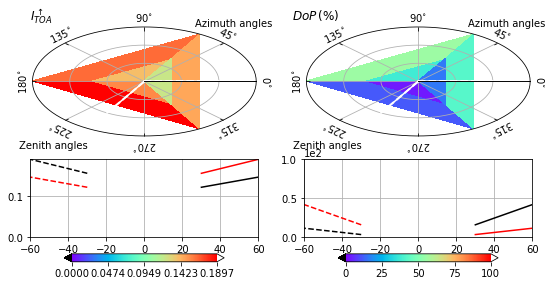

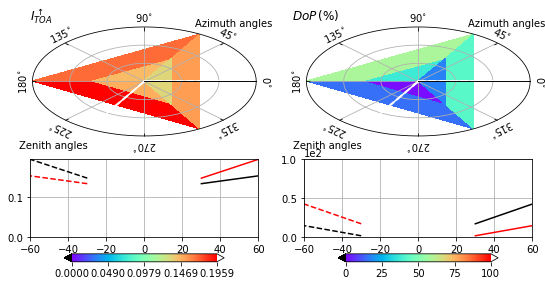

In [180]:
_=smartg_view(mBa.sub( d={'wavelength':Idx(450)}), field='up (TOA)', ind=[0,2], Imax=None, Imin=0)
_=smartg_view(mB.sub( d={'wavelength':Idx(450)}), field='up (TOA)', ind=[0,2], Imax=None, Imin=0)

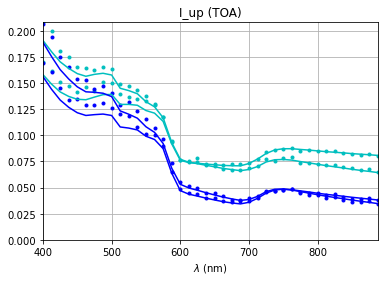

In [181]:
lut1_90 = mB ['I_up (TOA)'].sub({'Zenith angles':Idx([30,60]), 'Azimuth angles':Idx(90)})
lut1_0  = mB ['I_up (TOA)'].sub({'Zenith angles':Idx([30,60]), 'Azimuth angles':Idx(0)})
lut2_90 = mBa['I_up (TOA)'].sub({'Zenith angles':Idx([30,60]), 'Azimuth angles':Idx(90)})
lut2_0  = mBa['I_up (TOA)'].sub({'Zenith angles':Idx([30,60]), 'Azimuth angles':Idx(0)})
f = figure()
spectrum(lut1_90, vmin=0, vmax=None, sub=111,  fig=f, color='c', percent=False, fmt='.')
spectrum(lut1_0,  vmin=0, vmax=None, sub=None, fig=f, color='b', percent=False, fmt='.')
spectrum(lut2_90, vmin=0, vmax=None, sub=None, fig=f, color='c', percent=False, fmt='-')
spectrum(lut2_0,  vmin=0, vmax=None, sub=None, fig=f, color='b', percent=False, fmt='-')

<AxesSubplot:ylabel='TOA ref'>

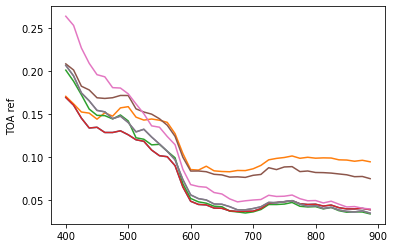

In [182]:
outputs = []
iup = mB[0]
za = [30,60]
aa = np.linspace(0,360,num=4)

for k in range(len(za)):
    for j in range(len(aa)):
        toa = []
        for i in range(len(wav)):
            toa.append(iup[i,j,k])
        outputs.append(toa)

outputs = pd.DataFrame(outputs, columns=wav)
# fig, ax = plt.subplots()
outputs.T.plot(legend=False,ylabel='TOA ref')

<AxesSubplot:ylabel='TOA ref'>

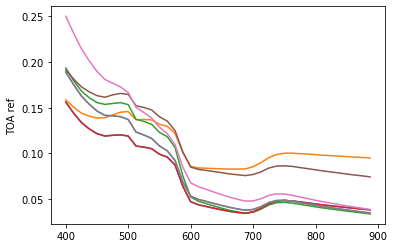

In [183]:
outputs = []
iup = mBa[0]
za = [30,60]
aa = np.linspace(0,360,num=4)

for k in range(len(za)):
    for j in range(len(aa)):
        toa = []
        for i in range(len(wav)):
            toa.append(iup[i,j,k])
        outputs.append(toa)

outputs = pd.DataFrame(outputs, columns=wav)
# fig, ax = plt.subplots()
outputs.T.plot(legend=False,ylabel='TOA ref')

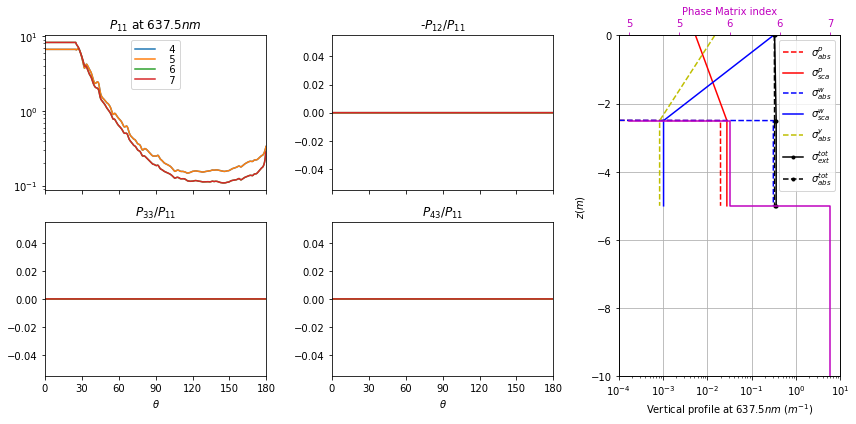

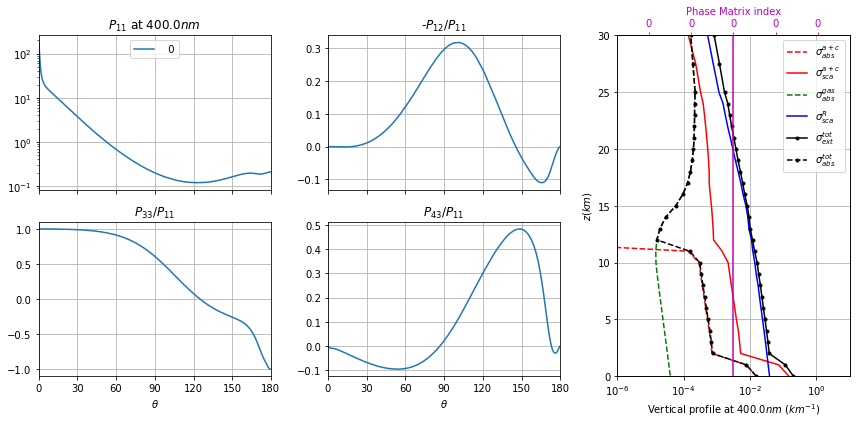

In [108]:
_=input_view(mBa, kind='oc', zmax=-10, iw=-1)
_=input_view(mBa, kind='atm', zmax=30)